In [115]:
from webscraping.scraper import fetch_all_csv_from_drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns


In [116]:
folder_id = "1EafyzmaIUfPRXzwt8s4TSOQcQ00U4BTF"
credentials_path = "/Users/rahilshaik/voyager-voting-clustering/voyager-voting-clusters-4f58cd67ebbb.json"

df = fetch_all_csv_from_drive(folder_id, credentials_path)

if df is not None:
    print(df.head())

Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 

In [117]:
df.head()

,christineoh51@berkeley.edu,4,source_file,5,2,3,Unnamed: 1,1
0,lilianxu@berkeley.edu,3.0,name_110.csv,NaN,NaN,NaN,NaN,NaN
1,mayurihebbar@berkeley.edu,2.0,name_110.csv,NaN,NaN,NaN,NaN,NaN
2,shivanisahni@berkeley.edu,4.0,name_110.csv,NaN,NaN,NaN,NaN,NaN
3,annacheng@berkeley.edu,5.0,name_110.csv,NaN,NaN,NaN,NaN,NaN
4,emilyynhi@berkeley.edu,3.0,name_110.csv,NaN,NaN,NaN,NaN,NaN


In [118]:
df_tst = df
df_tst.columns = ["email", "score", "source_file", "ignore", "ignore", "ignore", "ignore", "ignore"]

In [119]:
df_tst = df_tst[["email", "score", "source_file"]]

In [120]:
df_tst= df_tst.dropna(subset=["score"]).copy()
df_agg = df_tst.groupby("email")["score"].mean().reset_index()

In [121]:
df_agg.head()

,email,score
0,adorado@berkeley.edu,3.440000
1,anjalidixit@berkeley.edu,2.880000
2,annacheng@berkeley.edu,3.538462
3,benjamin.liang@berkeley.edu,2.916667
4,brennandai@berkeley.edu,3.307692


In [122]:
scaler = StandardScaler()
df_agg["score_scaled"] = scaler.fit_transform(df_agg[["score"]])

In [123]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_agg["cluster"] = kmeans.fit_predict(df_agg[["score_scaled"]])

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_30015/516282415.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=df_agg["cluster"], y=df_agg["score_scaled"], jitter=True, palette="viridis")


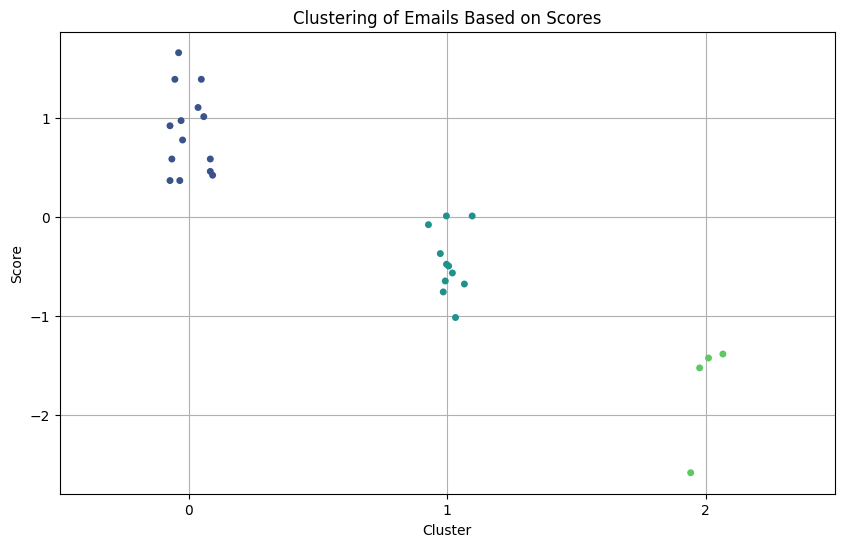

In [124]:
plt.figure(figsize=(10, 6))
sns.stripplot(x=df_agg["cluster"], y=df_agg["score_scaled"], jitter=True, palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Score")
plt.title("Clustering of Emails Based on Scores")
plt.grid()
plt.show()

In [129]:
df_agg.query("cluster == 1")["email"].unique()

array(['anjalidixit@berkeley.edu', 'benjamin.liang@berkeley.edu',
       'cindyw@berkeley.edu', 'emilyynhi@berkeley.edu',
       'ericwang0533@berkeley.edu', 'lilianxu@berkeley.edu',
       'mayurihebbar@berkeley.edu', 'nolancostin@berkeley.edu',
       'rpiao.26@berkeley.edu', 'saachi.goyal@berkeley.edu',
       'yashgk99@berkeley.edu'], dtype=object)